====data info====
p:
tensor([[0.000000, 1.000000],
        [0.292893, 1.707107],
        [1.000000, 2.000000]])


p_focal:
tensor([1, 1])


1-0 angle:45.00000125223908
2-0 angle:90.00000250447816
2-1 angle:44.999994422049916


0 length:1.0
1 length:1.0
2 length:1.0


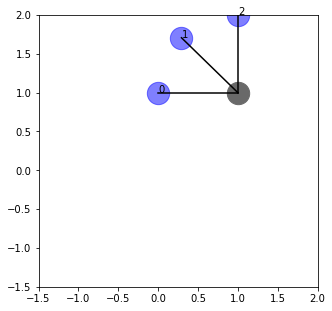

In [71]:
# the purpose of this test is to check if the 2D kernel can learn to generate pattern present in the training data
# step 1. test of data with same attributes with the same length
# step 2  test of data with same attributes with the different length
# step 3. test with different attributes  and different length

# data generation
import torch
import matplotlib.pyplot as plt
import math
from torch_geometric.data import Data
import numpy as np



def color_for_element(atomic_num):
    color ='lightgrey'
    if(atomic_num == 1):
        color = 'lightgrey'
    elif(atomic_num ==6):
        color = 'black'
    elif(atomic_num ==8):
        color = 'red'
    elif(atomic_num ==7):
        color = 'blue'
    return color

def angle_between_two_vectors(vector_1, vector_2):

#     print('\n')
#     print('vector1:')
#     print(vector_1)
#     print('vector2:')
#     print(vector_2)
    
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
#     print('norm vector1:')
#     print(unit_vector_1)
    
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
#     print('norm vector2:')
#     print(unit_vector_2)
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)
#     print(f'dot:{dot_product}')
    angle = np.arccos(dot_product)
    angle = angle/math.pi *180
    return angle

def edge_length(vector):
    return np.linalg.norm(vector)
    

def vis(data = None, x = None, x_focal = None, p=None, p_focal=None, edge_attr = None, vis_kernel=False):
    fig_size = 5
    marker_size = 500
    lower_bound = -1.5
    upper_bound = 2
    
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)


    if data is not None:
        try:
            p = data.p
            p_focal = data.p_focal

        except:
            raise Exception('In data, either center position p_focal or position p is not provided')
                  
        try:
            x = data.x
        except:
            x = None
        try:
            x_focal = data.x_focal
        except:
            x_focal = None
        try:
            edge_attr = data.edge_attr
        except:
            edge_attr = None
    else:
        if p is None or p_focal is None:
            raise Exception('either provide data, or provide both p and p_focal is provided')
    
    if(vis_kernel==False):
        print('====data info====')

        print('p:')
        print(p)

        if x is not None:
            print('\n')
            print('x:')
            print(x)

        if x_focal is not None:
            print('\n')
            print('x_focal:')
            print(x_focal)

        if p_focal is not None:
            print('\n')
            print('p_focal:')
            print(p_focal)

        if edge_attr is not None:
            print('\n')
            print('edge_attr:')
            print(edge_attr)
    
    
    print('\n')
    s = p.shape[0]
    calibrated_p = p-p_focal
    for i in range(s):
        for j in range(i):
            print(f'{i}-{j} angle:{angle_between_two_vectors(calibrated_p[i], calibrated_p[j])}')
    print('\n')
    
    for i in range(s):
        print(f'{i} length:{edge_length(calibrated_p[i])}')
        
    print('=========')

    # annotate and color
    for i in range(p.shape[0]):
        if x is None or ( vis_kernel == True):
            plt.annotate(i, (p[i,:]))
            color = 'blue'
        else:
            pt = Chem.GetPeriodicTable() 
            atomic_num = int(x[i,0].item())
            plt.annotate(pt.GetElementSymbol(atomic_num),(p[i,:]))
            marker_size = x[i,2].item()*500
            color = color_for_element(atomic_num)
            
        # draw neighors
        plt.scatter(p[i,0], p[i,1], color = color, s = marker_size, alpha = 0.5)
        
    # draw focal    
    plt.scatter(p_focal[0], p_focal[1], color = 'dimgrey', s= marker_size)
    
    # draw bonds
    for each_p in p:
        plt.plot([each_p[0], p_focal[0]],[each_p[1],p_focal[1]], color = 'black')
    plt.show()    

def get_kernel_from_model(model):
    params = model.parameters()
    param = list(params)

    x_center_array = param[0].detach().numpy()
    x_support_array = param[1].detach().numpy()
    edge_attr_support_array = param[2].detach().numpy()
    p_support_array = param[3].detach().numpy()
    output_kernel = Data(p_support = torch.tensor(p_support_array), x_support = torch.tensor(x_support_array), x_center = torch.tensor(x_center_array), edge_attr_support = torch.tensor(edge_attr_support_array))
    return output_kernel


def vis_kernel(kernel):
    
    kernel.x = x_support
    
    kernel.p = kernel.p_support  

    kernel.x_focal = kernel.x_center
    
    p_center = torch.tensor([0,0])    
    kernel.p_focal = p_center
    
    kernel.edge_attr = kernel.edge_attr_support
    
    
    print('====kernel info====')

    print('p_support:')
    print(p_support)

    if x is not None:
        print('\n')
        print('x_support:')
        print(x_support)

    if x_focal is not None:
        print('\n')
        print('x_center:')
        print(x_center)

    if p_focal is not None:
        print('\n')
        print('p_center:')
        print(p_center)

    if edge_attr is not None:
        print('\n')
        print('edge_attr_support:')
        print(edge_attr_support)
    
    
    vis(kernel, vis_kernel=True)


    
def vis_kernel_in_model(model):
    kernel = get_kernel_from_model(model)
    print(kernel)
    vis_kernel(kernel)

    
def rotate(p_center, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given p_center.

    The angle should be given in degrees.
    """
    angle = angle * math.pi/180
    
    ox, oy = p_center
#     print(f'ox:{ox}, oy:{oy}')
    px, py = point
#     print(f'px:{px}, py:{py}')
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return torch.tensor([qx, qy])

def tensor_rotate(p_center, points, angle):
    l = []
    for point in points:
        new_p = rotate(p_center, point, angle)
        l.append(new_p)
    l = torch.stack(l, dim=0)
#     print(f'f:{l.shape}')
    return torch.tensor(l)
        
# new_p = tensor_rotate(p_center, p, 180)
# # print(new_p)
# # vis(new_p, p_center)

# data_list = []
# for i in range(0, 370, 10):
#     new_p = tensor_rotate(p_center, p, i)
#     data = Data(p = new_p, p_center = p_center)
#     data_list.append(data)

# # for data in data_list:
# #     vis(data, p_center)


# translate
trans = torch.tensor([[1,1]])


# S = 3
x = torch.tensor([[1],[1],[1]], dtype = torch.float)
p = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1]], dtype = torch.float)
p+=trans
p_focal = torch.tensor([0,0]) + trans.squeeze(dim =0)


#S = 4
# data
# x = torch.tensor([[1],[1],[1],[1]], dtype = torch.float)
# p = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [math.sqrt(0.5), math.sqrt(0.5)]], dtype = torch.float)


vis(p = p, p_focal = p_focal)


calculating rdkit element representation lookup table
====data info====
p:
tensor([[ 1.299038e+00,  7.500000e-01],
        [-1.299038e+00,  7.500000e-01],
        [-2.775558e-16, -1.500000e+00]])


x:
tensor([[ 8.000000, 15.999000,  1.550000,  2.000000,  6.000000],
        [ 1.000000,  1.008000,  1.200000,  1.000000,  1.000000],
        [ 1.000000,  1.008000,  1.200000,  1.000000,  1.000000]])


x_focal:
tensor([ 6.000000, 12.011000,  1.700000,  4.000000,  4.000000])


p_focal:
tensor([-5.551115e-17, -5.551115e-17])


edge_attr:
tensor([2, 1, 1])


1-0 angle:120.00000333930423
2-0 angle:120.00000333930423
2-1 angle:120.00000333930423


0 length:1.5
1 length:1.5
2 length:1.5


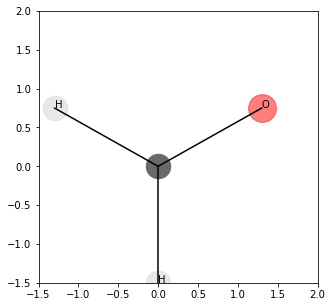

D:\Anaconda3\envs\conv_qsar\lib\site-packages\ipykernel_launcher.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [154]:
# test of p with different attributes
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit
import torch
from torch_geometric.data import Data

elements = ['H', 'C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I']
elem_lst =None


def lookup_from_rdkit(elements):
    global elem_lst

    if elem_lst is None:
        print('calculating rdkit element representation lookup table')
        elem_rep_lookup = []
        for elem in elements:
            pt = Chem.GetPeriodicTable() 

            if isinstance(elem, int):
                num=elem
                sym=pt.GetElementSymbol(num)
            else:
                num = pt.GetAtomicNumber(elem)
                sym = elem
            w = pt.GetAtomicWeight(elem)

            Rvdw = pt.GetRvdw(elem)
        #     Rcoval = pt.GetRCovalent(elem)
            valence = pt.GetDefaultValence(elem)
            outer_elec = pt.GetNOuterElecs(elem)

            elem_rep=[num, w,  Rvdw, valence, outer_elec]
#             print(elem_rep)


            elem_rep_lookup.append(elem_rep)
        elem_lst = elem_rep_lookup.copy()
        return elem_rep_lookup
    else:
        return elem_lst




def get_atom_rep(atomic_num, package='rdkit'):
    '''use rdkit or pymatgen to generate atom representation
    '''
    max_elem_num = 118
    element_nums= [x+1 for x in range(max_elem_num)]


    if package =='rdkit':
        elem_lst = lookup_from_rdkit(element_nums)
    elif package == 'pymatgen':
        raise Exception('pymatgen implementation is deprecated.')
        #elem_lst = lookup_from_pymatgen(element_nums)
    else:
        raise Exception('cannot generate atom representation lookup table')

    result = 0
    try:
        result = elem_lst[atomic_num - 1]
    except:
        print(f'error: atomic_num {atomic_num} does not exist')

    return result


def smiles2graph(D, smiles):
    if D==None:
        raise Exception('smiles2grpah() needs to input D to specifiy 2D or 3D graph generation.')
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    if D==2:
        rdkit.Chem.rdDepictor.Compute2DCoords(mol)
    if D==3:
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)
    
    conf = mol.GetConformer()
    
    atom_pos = []
    atom_attr =[]
    
    # get atom attributes and positions
    for i, atom in enumerate(mol.GetAtoms()):
        atomic_num = atom.GetAtomicNum()
        h = get_atom_rep(atomic_num)
    
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
    
    # get bond attributes
    edge_list = []
    edge_attr_list =[]
    for idx, edge in enumerate(mol.GetBonds()):
        i = edge.GetBeginAtomIdx()
        j = edge.GetEndAtomIdx()
        
        bond_attr = None
        bond_type = edge.GetBondType()
        if bond_type ==Chem.rdchem.BondType.SINGLE:
            bond_attr = [1]
        elif bond_type ==Chem.rdchem.BondType.DOUBLE:
            bond_attr = [2]
        elif bond_type ==Chem.rdchem.BondType.TRIPLE:
            bond_attr = [3]
        elif bond_type ==Chem.rdchem.BondType.AROMATIC:
            bond_attr = [4]     
            

        edge_list.append((i, j))
        edge_attr_list.append(bond_attr) 
#         print(f'i:{i} j:{j} bond_attr:{bond_attr}')

        edge_list.append((j, i))
        edge_attr_list.append(bond_attr)    
#         print(f'j:{j} j:{i} bond_attr:{bond_attr}')    
    
    x = torch.tensor(atom_attr)
    p = torch.tensor(atom_pos)
    edge_index = torch.tensor(edge_list).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list)
        
    return x, p, edge_index, edge_attr

smiles = 'C(=O)([H])[H]'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# for 3D
# AllChem.EmbedMolecule(mol)
# AllChem.UFFOptimizeMolecule(mol)
# conf = mol.GetConformer()


# for 2D
rdkit.Chem.rdDepictor.Compute2DCoords(mol)
conf = mol.GetConformer()
atom_pos = []
atom_attr =[]
x_focal = None
for i, atom in enumerate(mol.GetAtoms()):
    atomic_num = atom.GetAtomicNum()
    h = get_atom_rep(atomic_num, 'rdkit')
    if atomic_num == 6:
        p_focal = torch.tensor([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z ])
        x_focal = torch.tensor(h)
    else:
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
        
edge_attr = []
for j, edge in enumerate(mol.GetBonds()):
    bond_type = edge.GetBondType()
    if bond_type ==Chem.rdchem.BondType.SINGLE:
        edge_attr.append(1)
    elif bond_type ==Chem.rdchem.BondType.DOUBLE:
        edge_attr.append(2)
    elif bond_type ==Chem.rdchem.BondType.TRIPLE:
        edge_attr.append(3)
    elif bond_type ==Chem.rdchem.BondType.AROMATIC:
        edge_attr.append(4)
edge_attr = torch.tensor(edge_attr)
                              
p = torch.tensor(atom_pos)
x = torch.tensor(atom_attr)                              

# print(p)
# print(origin)
# print(x)
                            
data = Data(p=p, x=x, x_focal=x_focal, edge_attr=edge_attr, p_focal=p_focal)
# print(data)
vis(data=data)

data_list = []
for i in range(0, 370, 10):
    new_p = tensor_rotate(p_focal, p, i)
    data = Data(p = new_p, p_focal = p_focal, x=x, x_focal = x_focal, edge_attr = edge_attr)
    data_list.append(data)
#     vis(data=data)



In [86]:
# conv with attributes
# kernels
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import degree

import torch
from torch.nn import CosineSimilarity, Module, ModuleList, Linear, Sigmoid
from torch.nn.parameter import Parameter

from itertools import permutations
import math


# kernel = Data(p_support = p_support)
# same_kernel = Data(p_support = p)
# sig = Sigmoid()



class KernelConv(Module):
    def __init__(self, D=None, num_supports=None, node_attr_dim=None, edge_attr_dim=None, init_kernel:'type(Data)'=None):
        super(KernelConv, self).__init__()
        if init_kernel is None:
            if (D is None) or (num_supports is None) or (node_attr_dim is None) or (edge_attr_dim is None):
                raise Exception('either convolution dimention D, number of support num_supports or feature dimension node_attr_dim is not specified')
            else:
                init_kernel = Data(x_center = torch.randn(1, node_attr_dim),  x_support = torch.randn(num_supports,node_attr_dim), edge_attr_support = torch.randn(num_supports, edge_attr_dim), p_support = torch.randn(num_supports,D))

                
        x_center_tensor = init_kernel.x_center
        self.x_center = Parameter(x_center_tensor)

        x_support_tensor = init_kernel.x_support
        self.x_support = Parameter(x_support_tensor)
        
        edge_attr_support_tensor = init_kernel.edge_attr_support
        self.edge_attr_support = Parameter(edge_attr_support_tensor)
        
        p_support_tensor = init_kernel.p_support
        self.p_support = Parameter(p_support_tensor)
        

    def permute(self, x):
        rows = x.shape[0]
        l = [x[torch.tensor(permute)] for permute in list(permutations(range(rows)))]
        return l        
        
    def intra_angle(self,p:'shape(s,D)'):
        '''
        angles between each row vectors
        ''' 
        cos = CosineSimilarity(dim = 1)
        new_p = torch.roll(p,1,0)
        sc:'shape(s)' = cos(new_p, p)
        
        return sc  
    
    def get_angle_score(self, p, p_support):
        cos = CosineSimilarity(dim = 0)
#         print('p_dist:')
        inter_p_dist = self.intra_angle(p)
#         print('\n')
#         print('s_dist:')
        inter_p_support_dist = self.intra_angle(p_support)
#         print(f'inter_p_support_dist:{inter_p_support_dist}')
        sc = cos(inter_p_dist, inter_p_support_dist)
#         sc = torch.dot(inter_p_dist, inter_p_support_dist.T)
#         print(sc)
        return sc

    def get_length_score(self, p, p_support):
        len_p = torch.norm(p, dim = -1)
        len_p_support = torch.norm(p_support, dim = -1)
        
#         print('len_p')
#         print(len_p)
#         print(len_p_support)
        
        # inverse of L2 norm
        diff = torch.square(len_p - len_p_support)
        sc = torch.sum(diff)
        sc = torch.atan(1/sc)
    
#         print(sc)
        return sc
    
    def get_support_attribute_score(self, x_nei, x_support:'shape(s, d)'):

        # inverse of L2 norm
#         print('x_nei')
#         print(x_nei)
#         print('x_support')
#         print(x_support)
        diff = torch.square(x_nei - x_support)
        sc = torch.sum(diff)
        sc:'shape([])' = torch.atan(1/sc)
        return sc
    
    def get_center_attribute_score(self, x_focal, x_center):
        # inverse of L2 norm
#         print(f'center attri:{type(x_focal)}, {type(x_center)}')
#         print(f'center attri:{x_focal.shape}, {x_center.shape}')
#         print(x_focal)
#         print(x_center)
        diff = torch.square(x_focal - x_center)
        sc = torch.sum(diff)
        sc:'shape([])' = torch.atan(1/sc)
        return sc
    
    def get_edge_attribute_score(self, edge_attr_nei, edge_attr_support):
#         print('edge_attr_nei')
#         print(edge_attr_nei)
#         print('edge_attr_support')
#         print(edge_attr_support)
        diff = torch.square(edge_attr_nei - edge_attr_support)
        sc = torch.sum(diff)
        sc:'shape([])' = torch.atan(1/sc)
        return sc
    
    def forward(self, *argv, **kwargv):
        if len(argv)!=0:
            raise Exception('Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')
        
        if len(kwargv) == 1:
            x = kwargv['data'].x
            edge_index = kwargv['data'].edge_index
            edge_attr = kwargv['data'].edge_attr
            p = kwargv['data'].p
            x_focal = kwargv['data'].x_focal
        else:
            x = kwargv['x']
            edge_index = kwargv['edge_index']
            edge_attr = kwargv['edge_attr']
            p = kwargv['p']
            x_focal = kwargv['x_focal']
        
       
        
        
        x_center = self.x_center
        x_support = self.x_support
        edge_attr_support = self.edge_attr_support
        p_support = self.p_support            

        #calibrate p
        p = p-p_focal
        
        # calculate the angle score
        p_support_list = self.permute(p_support)
        x_support_list = self.permute(x_support)
        edge_attr_support_list = self.permute(edge_attr_support)
     
        best_angle_sc = torch.tensor(-float('Inf'))
        best_angle_sc_index = 0
        for i, each_p_support in enumerate(p_support_list):
            angle_sc = self.get_angle_score(p, each_p_support)

            if angle_sc > best_angle_sc:
                best_angle_sc_index = i
                best_angle_sc = angle_sc
        
        # get the p and p_support combination that gives the best angle score
        best_p_support = p_support_list[best_angle_sc_index]
        # calculate the length score for the best combination
        length_sc = self.get_length_score(p, best_p_support)

        # calculate the support attribute score for the best combination
        best_x_support = x_support_list[best_angle_sc_index]
        supp_attr_sc = self.get_support_attribute_score(x, best_x_support)
        
        # calculate the center attribute score
        center_attr_sc = self.get_center_attribute_score(x_focal, x_center)
        
        # calculate the edge attribute score
        best_edge_attr_support = edge_attr_support_list[best_angle_sc_index]
        edge_attr_support_sc = self.get_edge_attribute_score(edge_attr, best_edge_attr_support)
        
        # calculate the edge attribute score
#         edge_attr_supportc = self.get_edge_attribute_score(edge_attr_nei, edge_attr_support)
        
        
        # convert each score to correct dimension
        angle_sc = best_angle_sc.unsqueeze(dim = 0)
        length_sc = length_sc.unsqueeze(dim = 0)
        supp_attr_sc = supp_attr_sc.unsqueeze(dim=0)
        center_attr_sc = center_attr_sc.unsqueeze(dim=0)
        edge_attr_support_sc = edge_attr_support_sc.unsqueeze(dim=0)
        
        
        max_atan = torch.tensor([math.pi/2]) # the maxium value a arctain function can get
        one = torch.tensor([1])
        
        sc = torch.atan(1/
                        (torch.square(length_sc-max_atan) + 
                         torch.square(angle_sc-one)  + 
                         torch.square(supp_attr_sc-max_atan) +
                         torch.square(center_attr_sc - max_atan)+
                         torch.square(edge_attr_support_sc-max_atan)
                                     ))
        
        print('\n')
        print(f'len sc:{length_sc.item()}')
        print(f'angle sc:{best_angle_sc.item()}')
        print(f'support attribute_sc:{supp_attr_sc.item()}')
        print(f'edge attribute score:{edge_attr_support_sc.item()}')
        print(f'total sc: {sc.item()}')
        return sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc


Data(edge_attr_support=[3], p_support=[3, 2], x_center=[5], x_support=[3, 5])
====kernel info====
p_support:
tensor([[ 0.205456,  0.956228],
        [-0.249660, -0.567454],
        [ 0.209608, -0.210819]])


x_support:
tensor([[ 8.000000, 15.999000,  1.550000,  2.000000,  6.000000],
        [ 8.000000, 15.999000,  1.550000,  2.000000,  6.000000],
        [ 8.000000, 15.999000,  1.550000,  2.000000,  6.000000]])


x_center:
tensor([16.000000, 32.067001,  1.800000,  2.000000,  6.000000])


p_center:
tensor([0, 0])


edge_attr_support:
tensor([ 1.164124,  1.166023, -0.590238])


1-0 angle:168.37841081542297
2-0 angle:123.03880914255625
2-1 angle:68.58278322974428


0 length:0.9780513644218445
1 length:0.6199474334716797
2 length:0.29728826880455017


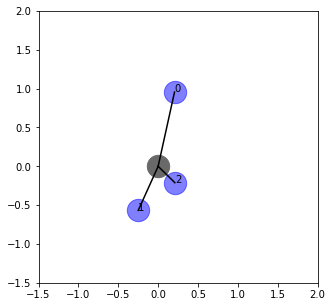

In [87]:
# reset kernel and check kernel before training with attributed data


#==================standard kernel===================
# # S = 3
# S = 3
# x_center = torch.tensor([[1]], dtype = torch.float)
# x_support = torch.tensor([[1],[1],[1]], dtype = torch.float)
# p_support = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)

# # # S = 4
# # # kernel
# # S = 4
# # x_center = torch.tensor([[1]], dtype = torch.float)
# # x_support = torch.tensor([[1],[1],[1]], dtype = torch.float)
# # p_support = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1], [math.sqrt(0.5), -math.sqrt(0.5)]], dtype = torch.float)
#======================================================

s =3

h_list = []
for i in range(s):
    h = get_atom_rep(8, 'rdkit')
    h_list.append(h)
x_support = torch.tensor(h_list)

p_support = torch.randn(s, 2)

x_center = torch.tensor(get_atom_rep(16, 'rdkit'))

edge_attr_support = torch.randn(3)

init_kernel = Data(x_center = x_center, x_support = x_support, p_support=p_support, edge_attr_support = edge_attr_support)

    
# randomize kernel
model = KernelConv(init_kernel=init_kernel)
vis_kernel_in_model(model)



In [88]:
model(data=data)



len sc:0.3814135193824768
angle sc:0.5678321719169617
support attribute_sc:0.001667484757490456
edge attribute score:0.2980576753616333
total sc: 0.12216813862323761


(tensor([0.122168], grad_fn=<AtanBackward>),
 tensor([0.381414], grad_fn=<UnsqueezeBackward0>),
 tensor([0.567832], grad_fn=<UnsqueezeBackward0>),
 tensor([0.001667], grad_fn=<UnsqueezeBackward0>),
 tensor([0.001960], grad_fn=<UnsqueezeBackward0>),
 tensor([0.298058], grad_fn=<UnsqueezeBackward0>))

In [89]:
# training with attributed data
from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
import random

torch.set_printoptions(precision=6)
random.seed(None)
optimizer = Adam(model.parameters(), lr=0.01)  # Define optimizer.

# Loss func selection
criterion = MSELoss()
# criterion = CosineSimilarity(dim = 0)
# criterion = CrossEngropyLoss


def train():
    random.shuffle(data_list)
    for data in data_list:
        sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = model(data=data)
        label = torch.tensor(math.pi/2, dtype= torch.float)
#         print(out)
        loss = criterion(sc, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('\n')
    print(f'loss:{loss.item()}')
    print(f'len sc:{length_sc.item()}')
    print(f'angle sc:{angle_sc.item()}')
    print(f'support attribute_sc:{supp_attr_sc.item()}')
    print(f'edge attribute score:{edge_attr_support_sc.item()}')
    print(f'total sc: {sc.item()}')    

for i in range(20):
    print(f'========epoch {i}========')
    train()
    
    # turn on this to visulize each step
#     params = model.parameters()
#     param = list(params)[0].detach().numpy()
#     vis(param, p_support_origin)
    


========epoch 0========


len sc:0.3814135193824768
angle sc:0.5678322315216064
support attribute_sc:0.001667484757490456
edge attribute score:0.2980576753616333
total sc: 0.12216813862323761


len sc:0.38586848974227905
angle sc:0.593015730381012
support attribute_sc:0.0016706327442079782
edge attribute score:0.30256786942481995
total sc: 0.12281288951635361


len sc:0.3906174302101135
angle sc:0.6184865832328796
support attribute_sc:0.0016706250607967377
edge attribute score:0.30034390091896057
total sc: 0.1231994479894638


len sc:0.3956702947616577
angle sc:0.6438028216362
support attribute_sc:0.001673202496021986
edge attribute score:0.3035275340080261
total sc: 0.12378622591495514


len sc:0.401043176651001
angle sc:0.6684448719024658
support attribute_sc:0.0016750567592680454
edge attribute score:0.15113216638565063
total sc: 0.11825210601091385


len sc:0.4067390561103821
angle sc:0.6916818618774414
support attribute_sc:0.0016786844935268164
edge attribute score:0.3105835318565



len sc:1.4870861768722534
angle sc:0.8963220119476318
support attribute_sc:0.001980387605726719
edge attribute score:0.9711897969245911
total sc: 0.18653059005737305


len sc:1.488110899925232
angle sc:0.8991308212280273
support attribute_sc:0.0019847359508275986
edge attribute score:0.9808543920516968
total sc: 0.18695345520973206


len sc:1.489109754562378
angle sc:0.901862382888794
support attribute_sc:0.0019275882514193654
edge attribute score:0.37559986114501953
total sc: 0.15580202639102936


len sc:1.4900645017623901
angle sc:0.9044551849365234
support attribute_sc:0.0019936312455683947
edge attribute score:1.0029010772705078
total sc: 0.18788889050483704


len sc:1.4910011291503906
angle sc:0.9069754481315613
support attribute_sc:0.0019336299737915397
edge attribute score:0.38381579518318176
total sc: 0.15630687773227692


len sc:1.4919005632400513
angle sc:0.9093666672706604
support attribute_sc:0.002002499997615814
edge attribute score:1.026639461517334
total sc: 0.18885880



loss:1.9152727127075195
len sc:1.525395393371582
angle sc:0.9627291560173035
support attribute_sc:0.0021611519623547792
edge attribute score:0.9662514925003052
total sc: 0.18686261773109436
========epoch 4========


len sc:1.525891661643982
angle sc:0.9631704688072205
support attribute_sc:0.002238377695903182
edge attribute score:1.2243139743804932
total sc: 0.195742666721344


len sc:1.5263818502426147
angle sc:0.9636023640632629
support attribute_sc:0.0021687536500394344
edge attribute score:0.9717297554016113
total sc: 0.18709754943847656


len sc:1.5268622636795044
angle sc:0.9640224575996399
support attribute_sc:0.0020762509666383266
edge attribute score:0.5350512266159058
total sc: 0.16524647176265717


len sc:1.5273252725601196
angle sc:0.9644247889518738
support attribute_sc:0.0021767248399555683
edge attribute score:0.9799851775169373
total sc: 0.18744483590126038


len sc:1.5277800559997559
angle sc:0.9648171663284302
support attribute_sc:0.0022562427911907434
edge attribut



len sc:1.543207049369812
angle sc:0.9774718284606934
support attribute_sc:0.0023423759266734123
edge attribute score:0.9373443722724915
total sc: 0.18575695157051086


len sc:1.543421745300293
angle sc:0.9776473045349121
support attribute_sc:0.002532074460759759
edge attribute score:1.265499472618103
total sc: 0.19691094756126404


len sc:1.5436344146728516
angle sc:0.9778211712837219
support attribute_sc:0.002538221189752221
edge attribute score:1.2653937339782715
total sc: 0.1969105750322342


len sc:1.5438448190689087
angle sc:0.977993369102478
support attribute_sc:0.00254467292688787
edge attribute score:1.2664260864257812
total sc: 0.19693680107593536


len sc:1.5440529584884644
angle sc:0.9781637191772461
support attribute_sc:0.0025514024309813976
edge attribute score:1.2684767246246338
total sc: 0.1969866007566452


len sc:1.544258952140808
angle sc:0.97833251953125
support attribute_sc:0.0023584363516420126
edge attribute score:0.9329668879508972
total sc: 0.18557506799697876



len sc:1.5513978004455566
angle sc:0.9841992259025574
support attribute_sc:0.0025174550246447325
edge attribute score:0.9672757387161255
total sc: 0.18710099160671234


len sc:1.5515143871307373
angle sc:0.9842949509620667
support attribute_sc:0.002520458772778511
edge attribute score:0.9657496809959412
total sc: 0.18703843653202057


len sc:1.5516291856765747
angle sc:0.9843893647193909
support attribute_sc:0.0028639878146350384
edge attribute score:1.237226128578186
total sc: 0.19632114470005035


len sc:1.5517432689666748
angle sc:0.9844830632209778
support attribute_sc:0.002871026284992695
edge attribute score:1.237769365310669
total sc: 0.1963367462158203


len sc:1.5518566370010376
angle sc:0.9845762252807617
support attribute_sc:0.0023416317999362946
edge attribute score:0.6278396844863892
total sc: 0.1705169528722763


len sc:1.5519667863845825
angle sc:0.9846667647361755
support attribute_sc:0.0025332702789455652
edge attribute score:0.9632158875465393
total sc: 0.1869373023



len sc:1.5561275482177734
angle sc:0.9880762696266174
support attribute_sc:0.0032778677996248007
edge attribute score:1.3000611066818237
total sc: 0.19787606596946716


len sc:1.5561987161636353
angle sc:0.9881344437599182
support attribute_sc:0.0032849994022399187
edge attribute score:1.2950587272644043
total sc: 0.1977723240852356


len sc:1.5562697649002075
angle sc:0.9881925582885742
support attribute_sc:0.003292859997600317
edge attribute score:1.291457176208496
total sc: 0.19769711792469025


len sc:1.5563406944274902
angle sc:0.9882503747940063
support attribute_sc:0.0033013815991580486
edge attribute score:1.289151906967163
total sc: 0.1976493000984192


len sc:1.5564113855361938
angle sc:0.9883082509040833
support attribute_sc:0.003310505533590913
edge attribute score:1.2880359888076782
total sc: 0.19762715697288513


len sc:1.556481957435608
angle sc:0.9883657693862915
support attribute_sc:0.0026474816258996725
edge attribute score:0.9114208221435547
total sc: 0.18475456535

total sc: 0.19872811436653137


len sc:1.559367060661316
angle sc:0.9907169342041016
support attribute_sc:0.0038632939103990793
edge attribute score:1.3417102098464966
total sc: 0.19881503283977509


len sc:1.5594161748886108
angle sc:0.9907570481300354
support attribute_sc:0.003878403455018997
edge attribute score:1.3465330600738525
total sc: 0.1989034116268158


len sc:1.5594652891159058
angle sc:0.9907968044281006
support attribute_sc:0.003893937449902296
edge attribute score:1.351483702659607
total sc: 0.1989923119544983


len sc:1.559514045715332
angle sc:0.990836501121521
support attribute_sc:0.002717662835493684
edge attribute score:0.8380643129348755
total sc: 0.18142642080783844


len sc:1.559561848640442
angle sc:0.9908754229545593
support attribute_sc:0.003924056421965361
edge attribute score:1.3589861392974854
total sc: 0.19912490248680115


len sc:1.5596096515655518
angle sc:0.9909142255783081
support attribute_sc:0.002716807648539543
edge attribute score:0.831712484359741

total sc: 0.1822279691696167


len sc:1.5615497827529907
angle sc:0.9924898147583008
support attribute_sc:0.004680124577134848
edge attribute score:1.3403992652893066
total sc: 0.19896158576011658


len sc:1.5615841150283813
angle sc:0.9925176501274109
support attribute_sc:0.004697466269135475
edge attribute score:1.3392608165740967
total sc: 0.19894464313983917


len sc:1.561618447303772
angle sc:0.992545485496521
support attribute_sc:0.004715777467936277
edge attribute score:1.338932991027832
total sc: 0.19894243776798248


len sc:1.561652660369873
angle sc:0.9925732016563416
support attribute_sc:0.004734978545457125
edge attribute score:1.339338779449463
total sc: 0.19895362854003906


len sc:1.5616868734359741
angle sc:0.9926009774208069
support attribute_sc:0.002711288398131728
edge attribute score:0.8562976121902466
total sc: 0.18234992027282715


len sc:1.561720371246338
angle sc:0.9926281571388245
support attribute_sc:0.0027109088841825724
edge attribute score:0.857671022415161



len sc:1.5641653537750244
angle sc:0.9946090579032898
support attribute_sc:0.007316759321838617
edge attribute score:1.3902872800827026
total sc: 0.2002815455198288


len sc:1.5641859769821167
angle sc:0.9946258664131165
support attribute_sc:0.002504854928702116
edge attribute score:0.7893112897872925
total sc: 0.1792420744895935


len sc:1.5642062425613403
angle sc:0.9946422576904297
support attribute_sc:0.007406349293887615
edge attribute score:1.3937201499938965
total sc: 0.20034635066986084


len sc:1.564226508140564
angle sc:0.9946585893630981
support attribute_sc:0.007450383622199297
edge attribute score:1.3947199583053589
total sc: 0.20036835968494415


len sc:1.5642467737197876
angle sc:0.9946749210357666
support attribute_sc:0.007495975121855736
edge attribute score:1.3960551023483276
total sc: 0.20039516687393188


len sc:1.5642669200897217
angle sc:0.9946912527084351
support attribute_sc:0.007543031591922045
edge attribute score:1.3976845741271973
total sc: 0.2004260569810



len sc:1.565102458000183
angle sc:0.995367705821991
support attribute_sc:0.010140178725123405
edge attribute score:1.3856266736984253
total sc: 0.20071804523468018


len sc:1.5651181936264038
angle sc:0.9953805208206177
support attribute_sc:0.010212200693786144
edge attribute score:1.3869775533676147
total sc: 0.20075029134750366


len sc:1.565134048461914
angle sc:0.9953933954238892
support attribute_sc:0.002306782640516758
edge attribute score:0.7938666939735413
total sc: 0.17957575619220734


len sc:1.5651495456695557
angle sc:0.9954058527946472
support attribute_sc:0.010354621335864067
edge attribute score:1.38820481300354
total sc: 0.20079292356967926


len sc:1.5651650428771973
angle sc:0.9954184293746948
support attribute_sc:0.010425708256661892
edge attribute score:1.3882699012756348
total sc: 0.20080621540546417


len sc:1.5651806592941284
angle sc:0.9954310655593872
support attribute_sc:0.010500051081180573
edge attribute score:1.388807773590088
total sc: 0.2008268833160400



len sc:1.5658210515975952
angle sc:0.9959495067596436
support attribute_sc:0.015058777295053005
edge attribute score:1.3839097023010254
total sc: 0.2015160173177719


len sc:1.5658339262008667
angle sc:0.9959598183631897
support attribute_sc:0.015191308222711086
edge attribute score:1.3824492692947388
total sc: 0.20151567459106445


len sc:1.5658468008041382
angle sc:0.9959702491760254
support attribute_sc:0.015330366790294647
edge attribute score:1.3816477060317993
total sc: 0.20152603089809418


len sc:1.5658596754074097
angle sc:0.9959806203842163
support attribute_sc:0.002016320126131177
edge attribute score:0.5861793756484985
total sc: 0.16873955726623535


len sc:1.565872073173523
angle sc:0.9959908127784729
support attribute_sc:0.002014671918004751
edge attribute score:0.5879431962966919
total sc: 0.16884095966815948


len sc:1.5658842325210571
angle sc:0.9960006475448608
support attribute_sc:0.015728309750556946
edge attribute score:1.3795000314712524
total sc: 0.201558366417



len sc:1.5663992166519165
angle sc:0.9964175820350647
support attribute_sc:0.024627001956105232
edge attribute score:1.3375113010406494
total sc: 0.2022385448217392


len sc:1.5664100646972656
angle sc:0.9964263439178467
support attribute_sc:0.002032397547736764
edge attribute score:0.8570655584335327
total sc: 0.1830368936061859


len sc:1.5664206743240356
angle sc:0.9964348077774048
support attribute_sc:0.02528035081923008
edge attribute score:1.340105652809143
total sc: 0.20238466560840607


len sc:1.5664312839508057
angle sc:0.9964434504508972
support attribute_sc:0.02561231702566147
edge attribute score:1.340897798538208
total sc: 0.20244893431663513


loss:1.8723746538162231
len sc:1.5664312839508057
angle sc:0.9964434504508972
support attribute_sc:0.02561231702566147
edge attribute score:1.340897798538208
total sc: 0.20244893431663513
========epoch 18========


len sc:1.5664418935775757
angle sc:0.9964520931243896
support attribute_sc:0.025962920859456062
edge attribute score:



len sc:1.5669119358062744
angle sc:0.9968328475952148
support attribute_sc:0.0019289564806967974
edge attribute score:0.8892896771430969
total sc: 0.18498001992702484


len sc:1.5669207572937012
angle sc:0.9968400597572327
support attribute_sc:0.060320548713207245
edge attribute score:1.308595061302185
total sc: 0.20672084391117096


len sc:1.566929578781128
angle sc:0.9968472123146057
support attribute_sc:0.0018419624539092183
edge attribute score:0.6001571416854858
total sc: 0.17011788487434387


len sc:1.5669381618499756
angle sc:0.9968540668487549
support attribute_sc:0.06301254779100418
edge attribute score:1.3053321838378906
total sc: 0.20702020823955536


len sc:1.5669468641281128
angle sc:0.9968611598014832
support attribute_sc:0.06445939093828201
edge attribute score:1.304703950881958
total sc: 0.2072053700685501


len sc:1.56695556640625
angle sc:0.9968681931495667
support attribute_sc:0.001836203970015049
edge attribute score:0.6046950817108154
total sc: 0.1703999787569046

====data info====
p:
tensor([[ 1.299038e+00,  7.500000e-01],
        [-1.299038e+00,  7.500000e-01],
        [-6.449498e-16, -1.500000e+00]])


x:
tensor([[ 8.000000, 15.999000,  1.550000,  2.000000,  6.000000],
        [ 1.000000,  1.008000,  1.200000,  1.000000,  1.000000],
        [ 1.000000,  1.008000,  1.200000,  1.000000,  1.000000]])


x_focal:
tensor([ 6.000000, 12.011000,  1.700000,  4.000000,  4.000000])


p_focal:
tensor([-5.551115e-17, -5.551115e-17])


edge_attr:
tensor([2, 1, 1])


1-0 angle:120.00000333930423
2-0 angle:120.00000333930423
2-1 angle:120.00000333930423


0 length:1.5
1 length:1.5
2 length:1.5


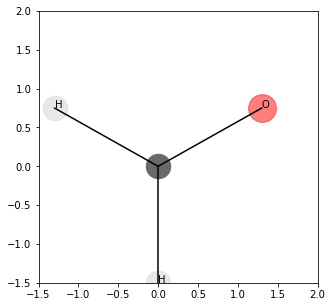

Data(edge_attr_support=[3], p_support=[3, 2], x_center=[5], x_support=[3, 5])
====kernel info====
p_support:
tensor([[-0.150145,  1.491821],
        [-1.186856, -0.905136],
        [ 1.291321, -0.636969]])


x_support:
tensor([[ 8.001401, 15.995784,  1.532888,  2.001528,  5.998483],
        [ 1.000202,  3.361014,  1.176905,  0.991354,  0.999330],
        [ 0.999413,  2.607628,  1.195571,  1.003852,  0.998414]])


x_center:
tensor([ 6.101332, 19.275261,  1.700000,  4.000000,  4.000000])


p_center:
tensor([0, 0])


edge_attr_support:
tensor([1.637095, 1.309630, 1.067605])


1-0 angle:121.58315922664315
2-0 angle:122.0029016718971
2-1 angle:116.41393545899408


0 length:1.499358057975769
1 length:1.4926146268844604
2 length:1.4398750066757202


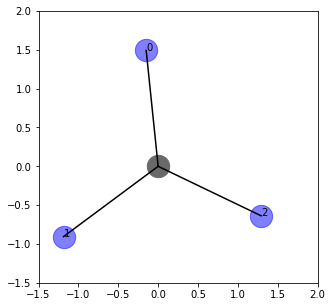



len sc:1.5671263933181763
angle sc:0.9970067143440247
support attribute_sc:0.001861536642536521
edge attribute score:0.8451701402664185
total sc: 0.1832316815853119


(tensor([0.183232], grad_fn=<AtanBackward>),
 tensor([1.567126], grad_fn=<UnsqueezeBackward0>),
 tensor([0.997007], grad_fn=<UnsqueezeBackward0>),
 tensor([0.001862], grad_fn=<UnsqueezeBackward0>),
 tensor([0.018944], grad_fn=<UnsqueezeBackward0>),
 tensor([0.845170], grad_fn=<UnsqueezeBackward0>))

In [90]:
# visualize kernel in the model

vis(data)

vis_kernel_in_model(model)

model(data=data)

In [97]:
# test of KernelSetConv

        
kernelset_2d = KernelSetConv(D = 2, node_attr_dim = 5, edge_attr_dim = 1)
for item in kernelset_2d.state_dict():
    print(item)


kernel_set.0.x_center
kernel_set.0.x_support
kernel_set.0.edge_attr_support
kernel_set.0.p_support
kernel_set.1.x_center
kernel_set.1.x_support
kernel_set.1.edge_attr_support
kernel_set.1.p_support
kernel_set.2.x_center
kernel_set.2.x_support
kernel_set.2.edge_attr_support
kernel_set.2.p_support
kernel_set.3.x_center
kernel_set.3.x_support
kernel_set.3.edge_attr_support
kernel_set.3.p_support


In [ ]:
# test of a graph

from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import degree

import torch
from torch.nn import ModuleList
from torch.nn import CosineSimilarity, Module, ModuleList, Linear, Sigmoid
from torch.nn.parameter import Parameter

from itertools import permutations
import math


class KernelConv(Module):
    def __init__(self, D=None, num_supports=None, node_attr_dim=None, edge_attr_dim=None, init_kernel:'type(Data)'=None):
        super(KernelConv, self).__init__()
        if init_kernel is None:
            if (D is None) or (num_supports is None) or (node_attr_dim is None) or (edge_attr_dim is None):
                raise Exception('either convolution dimention D, number of support num_supports or feature dimension node_attr_dim is not specified')
            else:
                init_kernel = Data(x_center = torch.randn(1, node_attr_dim),  x_support = torch.randn(num_supports,node_attr_dim), edge_attr_support = torch.randn(num_supports, edge_attr_dim), p_support = torch.randn(num_supports,D))

                
        x_center_tensor = init_kernel.x_center
        self.x_center = Parameter(x_center_tensor)

        x_support_tensor = init_kernel.x_support
        self.x_support = Parameter(x_support_tensor)
        
        edge_attr_support_tensor = init_kernel.edge_attr_support
        self.edge_attr_support = Parameter(edge_attr_support_tensor)
        
        p_support_tensor = init_kernel.p_support
        self.p_support = Parameter(p_support_tensor)
        

    def permute(self, x):
        rows = x.shape[0]
        l = [x[torch.tensor(permute)] for permute in list(permutations(range(rows)))]
        return l        
        
    def intra_angle(self,p:'shape(s,D)'):
        '''
        angles between each row vectors
        ''' 
        cos = CosineSimilarity(dim = 1)
        new_p = torch.roll(p,1,0)
        sc:'shape(s)' = cos(new_p, p)
        
        return sc  
    
    def get_angle_score(self, p, p_support):
        cos = CosineSimilarity(dim = 0)
#         print('p_dist:')
        inter_p_dist = self.intra_angle(p)
#         print('\n')
#         print('s_dist:')
        inter_p_support_dist = self.intra_angle(p_support)
#         print(f'inter_p_support_dist:{inter_p_support_dist}')
        sc = cos(inter_p_dist, inter_p_support_dist)
#         sc = torch.dot(inter_p_dist, inter_p_support_dist.T)
#         print(sc)
        return sc

    def get_length_score(self, p, p_support):
        len_p = torch.norm(p, dim = -1)
        len_p_support = torch.norm(p_support, dim = -1)
        
#         print('len_p')
#         print(len_p)
#         print(len_p_support)
        
        # inverse of L2 norm
        diff = torch.square(len_p - len_p_support)
        sc = torch.sum(diff)
        sc = torch.atan(1/sc)
    
#         print(sc)
        return sc
    
    def get_support_attribute_score(self, x_nei, x_support:'shape(s, d)'):

        # inverse of L2 norm
#         print('x_nei')
#         print(x_nei)
#         print('x_support')
#         print(x_support)
        diff = torch.square(x_nei - x_support)
        sc = torch.sum(diff)
        sc:'shape([])' = torch.atan(1/sc)
        return sc
    
    def get_center_attribute_score(self, x_focal, x_center):
        # inverse of L2 norm
#         print(f'center attri:{type(x_focal)}, {type(x_center)}')
#         print(f'center attri:{x_focal.shape}, {x_center.shape}')
#         print(x_focal)
#         print(x_center)
        diff = torch.square(x_focal - x_center)
        sc = torch.sum(diff)
        sc:'shape([])' = torch.atan(1/sc)
        return sc
    
    def get_edge_attribute_score(self, edge_attr_nei, edge_attr_support):
#         print('edge_attr_nei')
#         print(edge_attr_nei)
#         print('edge_attr_support')
#         print(edge_attr_support)
        diff = torch.square(edge_attr_nei - edge_attr_support)
        sc = torch.sum(diff)
        sc:'shape([])' = torch.atan(1/sc)
        return sc
    
    def calculate_total_score(self, x_focal, p_focal, x_neighbor, p_neighbor, edge_attr):
        # calibrate p_neighbor
        p_neighbor = p_neighbor - p_focal
        
        # get kernel params
        x_center = self.x_center
        x_support = self.x_support
        edge_attr_support = self.edge_attr_support
        p_support = self.p_support
        
        # calculate the angle score
        p_support_list = self.permute(p_support)
        x_support_list = self.permute(x_support)
        edge_attr_support_list = self.permute(edge_attr_support)
     
        best_angle_sc = torch.tensor(-float('Inf'))
        best_angle_sc_index = 0
        for i, each_p_support in enumerate(p_support_list):
            angle_sc = self.get_angle_score(p, each_p_support)

            if angle_sc > best_angle_sc:
                best_angle_sc_index = i
                best_angle_sc = angle_sc
        
        # get the p and p_support combination that gives the best angle score
        best_p_support = p_support_list[best_angle_sc_index]
        # calculate the length score for the best combination
        length_sc = self.get_length_score(p, best_p_support)

        # calculate the support attribute score for the best combination
        best_x_support = x_support_list[best_angle_sc_index]
        supp_attr_sc = self.get_support_attribute_score(x, best_x_support)
        
        # calculate the center attribute score
        center_attr_sc = self.get_center_attribute_score(x_focal, x_center)
        
        # calculate the edge attribute score
        best_edge_attr_support = edge_attr_support_list[best_angle_sc_index]
        edge_attr_support_sc = self.get_edge_attribute_score(edge_attr, best_edge_attr_support)
        
        # calculate the edge attribute score
#         edge_attr_supportc = self.get_edge_attribute_score(edge_attr_nei, edge_attr_support)
        
        
        # convert each score to correct dimension
        angle_sc = best_angle_sc.unsqueeze(dim = 0)
        length_sc = length_sc.unsqueeze(dim = 0)
        supp_attr_sc = supp_attr_sc.unsqueeze(dim=0)
        center_attr_sc = center_attr_sc.unsqueeze(dim=0)
        edge_attr_support_sc = edge_attr_support_sc.unsqueeze(dim=0)
        
        
        max_atan = torch.tensor([math.pi/2]) # the maxium value a arctain function can get
        one = torch.tensor([1])
        
        sc = torch.atan(1/
                        (torch.square(length_sc-max_atan) + 
                         torch.square(angle_sc-one)  + 
                         torch.square(supp_attr_sc-max_atan) +
                         torch.square(center_attr_sc - max_atan)+
                         torch.square(edge_attr_support_sc-max_atan)
                                     ))
        return sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc
    
   
    def forward(self, *argv, **kwargv):
        if len(kwargv) == 1:
            x_focal = kwargv['data'].x_focal
            p_focal = kwargv['data'].p_focal
            x_neighbor = kwargv['data'].x_neighbor
            p_neighbor = kwargv['data'].p_neighbor
            edge_attr = kwargv['data'].edge_attr
        else:
            x_focal = kwargv['x_focal']
            p_focal = kwargv['p_focal']
            x_neighbor = kwargv['x_neighbor']
            p_neighbor = kwargv['p_neighbor']
            edge_attr = kwargv['edge_attr']
        
            
#         x, x_focal, p, edge_attr, edge_index = self.convert_graph_to_receptive_field(x, p, edge_index, edge_attr)
 

        sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = self.calculate_total_score(x_focal, p_focal, x_neighbor, p_neighbor, edge_attr)
        
        
        print('\n')
        print(f'len sc:{length_sc.item()}')
        print(f'angle sc:{best_angle_sc.item()}')
        print(f'support attribute_sc:{supp_attr_sc.item()}')
        print(f'edge attribute score:{edge_attr_support_sc.item()}')
        print(f'total sc: {sc.item()}')
        print('hereeeeeeeee')
        return sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc

class KernelSetConv(Module):
    def __init__(self, D, node_attr_dim, edge_attr_dim):
        super(KernelSetConv, self).__init__()        
        
        kernel1 = KernelConv(D=D, num_supports=1, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
        kernel2 = KernelConv(D=D, num_supports=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
        kernel3 = KernelConv(D=D, num_supports=3, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
        kernel4 = KernelConv(D=D, num_supports=4, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
 
        self.kernel_set = ModuleList([kernel1, kernel2, kernel3, kernel4])

#         kernel_set = ModuleList(
#             [KernelConv(D=D, num_supports=1, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=3, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=4, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
#             ])

    def get_degree_index(self, x, edge_index):
        deg = degree(edge_index[0], x.shape[0])
        return deg
    
    def get_neighbor_index(self, edge_index, center_index):
#         print('edge_index')
#         print(edge_index)
#         print('\n')
#         print('center_index')
#         print(center_index)
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:,0] 
        return edge_index[1,d]
    
    def get_focal_nodes_of_degree(self, deg, x, p, edge_index):
        '''
        outputs
        ori_x: a feature matrix that only contains rows (i.e. the center node) having certain degree
        ori_p: a position matrix that only contains rows (i.e. the center node) having certain degree
        '''
        deg_index  = self.get_degree_index(x, edge_index)
        selected_index = (deg_index == deg).nonzero(as_tuple=True)
        x_focal = torch.index_select(input = x, dim = 0, index = selected_index[0]).unsqueeze(1)
        p_focal = torch.index_select(input = p, dim = 0, index = selected_index[0]).unsqueeze(1)
        
        return x_focal, p_focal

    
    def get_neighbor_nodes_of_degree(self, deg, x, p, edge_index, edge_attr):
        '''
        inputs:
        deg: the query degree
        num_focal: the number of focal nodes of degree deg in the graph
        
        outputs:
        nei_x: a feature matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        nei_p: a position matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        '''
        deg_index = self.get_degree_index(x, edge_index)
        center_index = (deg_index == deg).nonzero(as_tuple=True)[0]
        num_focal = len(center_index)
        
        nei_x_list = []
        nei_p_list = []
        nei_edge_list = []
        for i in range(num_focal):
            nei_index = self.get_neighbor_index(edge_index, center_index[i])
            
            nei_x = torch.index_select(x, 0, nei_index)
            nei_p = torch.index_select(p, 0, nei_index)
            print('\n')
            print('nei_index')
            print(nei_index)
            print('nei_index_processed')
            nei_edge

In [208]:
# test of a graph

from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import degree

import torch
from torch.nn import ModuleList
from torch.nn import CosineSimilarity, Module, ModuleList, Linear, Sigmoid
from torch.nn.parameter import Parameter

from itertools import permutations
import math


class KernelConv(Module):
    def __init__(self, D=None, num_supports=None, node_attr_dim=None, edge_attr_dim=None, init_kernel:'type(Data)'=None):
        super(KernelConv, self).__init__()
        if init_kernel is None:
            if (D is None) or (num_supports is None) or (node_attr_dim is None) or (edge_attr_dim is None):
                raise Exception('either convolution dimention D, number of support num_supports or feature dimension node_attr_dim is not specified')
            else:
                init_kernel = Data(x_center = torch.randn(1, node_attr_dim),  x_support = torch.randn(num_supports,node_attr_dim), edge_attr_support = torch.randn(num_supports, edge_attr_dim), p_support = torch.randn(num_supports,D))

                
        x_center_tensor = init_kernel.x_center
        self.x_center = Parameter(x_center_tensor)

        x_support_tensor = init_kernel.x_support
        self.x_support = Parameter(x_support_tensor)
        
        edge_attr_support_tensor = init_kernel.edge_attr_support
        self.edge_attr_support = Parameter(edge_attr_support_tensor)
        
        p_support_tensor = init_kernel.p_support
        self.p_support = Parameter(p_support_tensor)
        

    def permute(self, x):
        rows = x.shape[0]
        l = [x[torch.tensor(permute)] for permute in list(permutations(range(rows)))]
        return l        
        
    def intra_angle(self,p:'shape(s,D)'):
        '''
        angles between each row vectors
        ''' 
        cos = CosineSimilarity(dim = 1)
        new_p = torch.roll(p,1,0)
        sc:'shape(s)' = cos(new_p, p)
        
        return sc  
    
    def get_angle_score(self, p, p_support):
        cos = CosineSimilarity(dim = 0)
#         print('p_dist:')
        inter_p_dist = self.intra_angle(p)
#         print('\n')
#         print('s_dist:')
        inter_p_support_dist = self.intra_angle(p_support)
#         print(f'inter_p_support_dist:{inter_p_support_dist}')
        sc = cos(inter_p_dist, inter_p_support_dist)
#         sc = torch.dot(inter_p_dist, inter_p_support_dist.T)
#         print(sc)
        return sc

    def get_length_score(self, p, p_support):
        len_p = torch.norm(p, dim = -1)
        len_p_support = torch.norm(p_support, dim = -1)
        
#         print('len_p')
#         print(len_p)
#         print(len_p_support)
        
        # inverse of L2 norm
        diff = torch.square(len_p - len_p_support)
        sc = torch.sum(diff)
        sc = torch.atan(1/sc)
    
#         print(sc)
        return sc
    
    def get_support_attribute_score(self, x_nei, x_support:'shape(s, d)'):

        # inverse of L2 norm
#         print('x_nei')
#         print(x_nei)
#         print('x_support')
#         print(x_support)
        diff = torch.square(x_nei - x_support)
        sc = torch.sum(diff)
        sc:'shape([])' = torch.atan(1/sc)
        return sc
    
    def get_center_attribute_score(self, x_focal, x_center):
        # inverse of L2 norm
#         print(f'center attri:{type(x_focal)}, {type(x_center)}')
#         print(f'center attri:{x_focal.shape}, {x_center.shape}')
#         print(x_focal)
#         print(x_center)
        diff = torch.square(x_focal - x_center)
        sc = torch.sum(diff)
        sc:'shape([])' = torch.atan(1/sc)
        return sc
    
    def get_edge_attribute_score(self, edge_attr_nei, edge_attr_support):
#         print('edge_attr_nei')
#         print(edge_attr_nei)
#         print('edge_attr_support')
#         print(edge_attr_support)
        diff = torch.square(edge_attr_nei - edge_attr_support)
        sc = torch.sum(diff)
        sc:'shape([])' = torch.atan(1/sc)
        return sc
    
    def calculate_total_score(self, x_focal, p_focal, x_neighbor, p_neighbor, edge_attr):
        # calibrate p_neighbor
        p_neighbor = p_neighbor - p_focal
        
        # get kernel params
        x_center = self.x_center
        x_support = self.x_support
        edge_attr_support = self.edge_attr_support
        p_support = self.p_support
        
        # calculate the angle score
        p_support_list = self.permute(p_support)
        x_support_list = self.permute(x_support)
        edge_attr_support_list = self.permute(edge_attr_support)
     
        best_angle_sc = torch.tensor(-float('Inf'))
        best_angle_sc_index = 0
        for i, each_p_support in enumerate(p_support_list):
            angle_sc = self.get_angle_score(p, each_p_support)

            if angle_sc > best_angle_sc:
                best_angle_sc_index = i
                best_angle_sc = angle_sc
        
        # get the p and p_support combination that gives the best angle score
        best_p_support = p_support_list[best_angle_sc_index]
        # calculate the length score for the best combination
        length_sc = self.get_length_score(p, best_p_support)

        # calculate the support attribute score for the best combination
        best_x_support = x_support_list[best_angle_sc_index]
        supp_attr_sc = self.get_support_attribute_score(x, best_x_support)
        
        # calculate the center attribute score
        center_attr_sc = self.get_center_attribute_score(x_focal, x_center)
        
        # calculate the edge attribute score
        best_edge_attr_support = edge_attr_support_list[best_angle_sc_index]
        edge_attr_support_sc = self.get_edge_attribute_score(edge_attr, best_edge_attr_support)
        
        # calculate the edge attribute score
#         edge_attr_supportc = self.get_edge_attribute_score(edge_attr_nei, edge_attr_support)
        
        
        # convert each score to correct dimension
        angle_sc = best_angle_sc.unsqueeze(dim = 0)
        length_sc = length_sc.unsqueeze(dim = 0)
        supp_attr_sc = supp_attr_sc.unsqueeze(dim=0)
        center_attr_sc = center_attr_sc.unsqueeze(dim=0)
        edge_attr_support_sc = edge_attr_support_sc.unsqueeze(dim=0)
        
        
        max_atan = torch.tensor([math.pi/2]) # the maxium value a arctain function can get
        one = torch.tensor([1])
        
        sc = torch.atan(1/
                        (torch.square(length_sc-max_atan) + 
                         torch.square(angle_sc-one)  + 
                         torch.square(supp_attr_sc-max_atan) +
                         torch.square(center_attr_sc - max_atan)+
                         torch.square(edge_attr_support_sc-max_atan)
                                     ))
        return sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc
    
   
    def forward(self, *argv, **kwargv):
        if len(kwargv) == 1:
            x_focal = kwargv['data'].x_focal
            p_focal = kwargv['data'].p_focal
            x_neighbor = kwargv['data'].x_neighbor
            p_neighbor = kwargv['data'].p_neighbor
            edge_attr = kwargv['data'].edge_attr
        else:
            x_focal = kwargv['x_focal']
            p_focal = kwargv['p_focal']
            x_neighbor = kwargv['x_neighbor']
            p_neighbor = kwargv['p_neighbor']
            edge_attr = kwargv['edge_attr']
        
            
#         x, x_focal, p, edge_attr, edge_index = self.convert_graph_to_receptive_field(x, p, edge_index, edge_attr)
 

        sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = self.calculate_total_score(x_focal, p_focal, x_neighbor, p_neighbor, edge_attr)
        
        
        print('\n')
        print(f'len sc:{length_sc.item()}')
        print(f'angle sc:{best_angle_sc.item()}')
        print(f'support attribute_sc:{supp_attr_sc.item()}')
        print(f'edge attribute score:{edge_attr_support_sc.item()}')
        print(f'total sc: {sc.item()}')
        print('hereeeeeeeee')
        return sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc

class KernelSetConv(Module):
    def __init__(self, D, node_attr_dim, edge_attr_dim):
        super(KernelSetConv, self).__init__()        
        
        kernel1 = KernelConv(D=D, num_supports=1, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
        kernel2 = KernelConv(D=D, num_supports=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
        kernel3 = KernelConv(D=D, num_supports=3, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
        kernel4 = KernelConv(D=D, num_supports=4, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
 
        self.kernel_set = ModuleList([kernel1, kernel2, kernel3, kernel4])

#         kernel_set = ModuleList(
#             [KernelConv(D=D, num_supports=1, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=3, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=4, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
#             ])

    def get_degree_index(self, x, edge_index):
        deg = degree(edge_index[0], x.shape[0])
        return deg
    
    def get_neighbor_index(self, edge_index, center_index):
#         print('edge_index')
#         print(edge_index)
#         print('\n')
#         print('center_index')
#         print(center_index)
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:,0] 
        return edge_index[1,d]
    
    def get_focal_nodes_of_degree(self, deg, x, p, edge_index):
        '''
        outputs
        ori_x: a feature matrix that only contains rows (i.e. the center node) having certain degree
        ori_p: a position matrix that only contains rows (i.e. the center node) having certain degree
        '''
        deg_index  = self.get_degree_index(x, edge_index)
        selected_index = (deg_index == deg).nonzero(as_tuple=True)
        x_focal = torch.index_select(input = x, dim = 0, index = selected_index[0]).unsqueeze(1)
        p_focal = torch.index_select(input = p, dim = 0, index = selected_index[0]).unsqueeze(1)
        
        return x_focal, p_focal

    def get_edge_attr_support_from_center_node(self, edge_attr, edge_index, center_index):
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:,0]

        # normalize bond id
        e = (d/2).long()
        bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
        print('bond_id')
        print(bond_id)

        # select bond attributes with the bond id
        nei_edge_attr = torch.index_select(input = edge_attr, dim = 0, index = bond_id)

        return nei_edge_attr    
    
    def get_neighbor_nodes_and_edges_of_degree(self, deg, x, p, edge_index, edge_attr):
        '''
        inputs:
        deg: the query degree
        num_focal: the number of focal nodes of degree deg in the graph
        
        outputs:
        nei_x: a feature matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        nei_p: a position matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        '''
        deg_index = self.get_degree_index(x, edge_index)
        center_index = (deg_index == deg).nonzero(as_tuple=True)[0]
        num_focal = len(center_index)
#         print('center_index')
#         print(center_index)
        
        nei_x_list = []
        nei_p_list = []
        nei_edge_attr_list = []
        for i in range(num_focal):
            nei_index = self.get_neighbor_index(edge_index, center_index[i])
            
            nei_x = torch.index_select(x, 0, nei_index)
            nei_p = torch.index_select(p, 0, nei_index)
            nei_edge_attr = self.get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index[i])
#             print('\n nei_edge_attr')
#             print(nei_edge_attr)
            
            
            nei_x_list.append(nei_x)
            nei_p_list.append(nei_p)
            nei_edge_attr_list.append(nei_edge_attr)
            
        nei_x = torch.stack(nei_x_list, dim = 0)
        nei_p = torch.stack(nei_p_list, dim = 0)
        nei_edge_attr:'shape(num_focal, num_support*2, num_support_attr_dim)' = torch.stack(nei_edge_attr_list, dim = 0)
        
#         print('nei_edge_attr')
#         print(nei_edge_attr.shape)
        
        return nei_x, nei_p, nei_edge_attr
    
    def convert_graph_to_receptive_field(self, deg, x, p, edge_index, edge_attr):
        x_focal, p_focal = self.get_focal_nodes_of_degree(deg = deg, x = x, p=p, edge_index = edge_index)
        
        num_focal = x_focal.shape[0]
        x_neighbor, p_neighbor = self.get_neighbor_nodes_and_edges_of_degree(deg = deg, x = x, edge_index = edge_index, p=p, edge_attr = edge_attr)
#         print('x_neighbor')
#         print(x_neighbor) 
        
        return x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor
 
    def forward(self, *argv, **kwargv):
        '''
        inputs:
        data: graph data containing feature matrix, adjacency matrix, edge_attr matrix
        '''
        if len(argv)!=0:
            raise Exception('Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')
        
        if len(kwargv) == 1:
            x = kwargv['data'].x
            edge_index = kwargv['data'].edge_index
            edge_attr = kwargv['data'].edge_attr
            p = kwargv['data'].p
          
        else:
            x = kwargv['x']
            edge_index = kwargv['edge_index']
            edge_attr = kwargv['edge_attr']
            p = kwargv['p']
        
        print('edge_index')
        print(edge_index)
        
        print('edge_attr')
        print(edge_attr)
            
        # loop through all possbile degrees. i.e. 1 to 4 bonds
#         for deg in range(1,5):
        deg = 3
    
        x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor = self.convert_graph_to_receptive_field(deg, x, p, edge_index, edge_attr)  
            
        
        output = torch.cat([x(data = data) for x in self.kernel_set], dim=0)

    
# =====test of KernelConv===
def print_data(data):
    print('x:')
    print(data.x)
    
    print('\n')
    print('p')
    print(data.p)
    
    print('\n')
    print('edge_index')
    print(data.edge_index)
    
    print('\n')
    print('edge_attr')
    print(data.edge_attr)


# data prep
smiles = 'C(C(C=O)([H])[H])=S'
x, p, edge_index, edge_attr = smiles2graph(2, smiles)
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)
# print_data(data)

# model prep
node_attr_dim = x.shape[1]
edge_attr_dim = edge_attr.shape[1]
model = KernelSetConv(D=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)

# run
model(data = data)


# KernelConv test

edge_index
tensor([[0, 1, 1, 2, 2, 3, 0, 4, 0, 5, 1, 6, 1, 7, 2, 8],
        [1, 0, 2, 1, 3, 2, 4, 0, 5, 0, 6, 1, 7, 1, 8, 2]])
edge_attr
tensor([[1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
center_index
tensor([0, 2])
bond_id
tensor([0, 1, 6, 7, 8, 9])

 nei_edge_attr
tensor([[1],
        [1],
        [2],
        [2],
        [1],
        [1]])
bond_id
tensor([ 2,  3,  4,  5, 14, 15])

 nei_edge_attr
tensor([[1],
        [1],
        [2],
        [2],
        [1],
        [1]])
nei_edge_attr
torch.Size([2, 6, 1])


ValueError: too many values to unpack (expected 2)

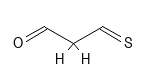
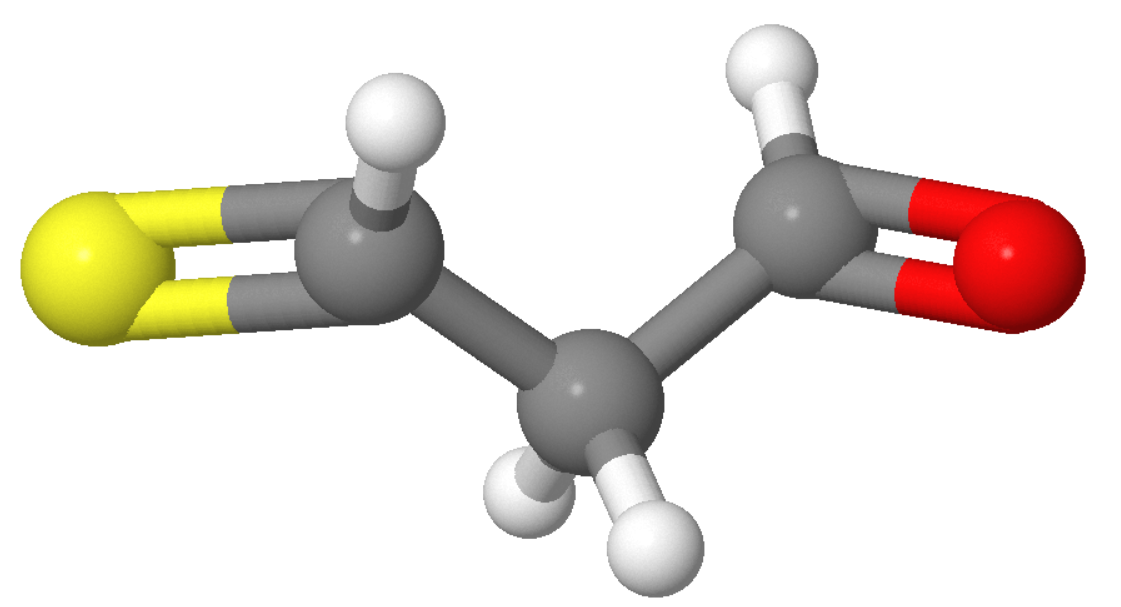

In [190]:
# test of getting neighbor_index from center_index
import torch
# tensor = torch.randint(15,(2,4), dtype=torch.long)
# print('tensor:')
# print(tensor)

# print('\n')
# print('values')
# values = torch.arange(10, dtype=torch.long)
# print(values)

# print('\n')
# a = tensor[0]

# print(a)
# b = a.unsqueeze(1) == values
# print(b)
# c = b.nonzero()
# print(c)
# d = c[:,0]
# print(d)
# tensor[1,d]


def get_neighbor_index(edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]
    
    return edge_index[1,d]

a = get_neighbor_index(tensor, values)

# print(f'a:{a}')

edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 0, 4, 0, 5, 1, 6, 1, 7, 2, 8], [1, 0, 2, 1, 3, 2, 4, 0, 5, 0, 6, 1, 7, 1, 8, 2]])
print(edge_index)
nei_index = torch.tensor([1,3,8])
print(nei_index)
edge_attr = torch.tensor([[1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

def get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]

    # normalize bond id
    e = (d/2).long()
    bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
    
    # select bond attributes with the bond id
    nei_edge_attr = torch.index_select(input = edge_attr, dim = 0, index = bond_id)
    
    return nei_edge_attr
center_index = torch.tensor([2])

a = get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index)
print(a)

tensor([[0, 1, 1, 2, 2, 3, 0, 4, 0, 5, 1, 6, 1, 7, 2, 8],
        [1, 0, 2, 1, 3, 2, 4, 0, 5, 0, 6, 1, 7, 1, 8, 2]])
tensor([1, 3, 8])
tensor([[1],
        [1],
        [2],
        [2],
        [1],
        [1]])
